In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv("raw_data.csv")
series_col = "Close_2330.TW"
exog_cols = [col for col in data.columns if col not in [series_col, "Date"]]
orig_dates = data.index.copy()
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()
full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data_full = data.reindex(full_index)
price_cols = [c for c in data_full.columns if 'Close' in c]
volume_cols = [c for c in data_full.columns if 'Volume' in c]
return_cols = [c for c in data_full.columns if 'Return' in c]
data_full = data_full.iloc[3:]
# If you want to mark weekends explicitly:
data_full[price_cols] = data_full[price_cols].ffill()
data_full[volume_cols] = data_full[volume_cols].fillna(0)
data_full[return_cols] = data_full[return_cols].fillna(0)
data_full['is_weekend'] = data_full.index.dayofweek >= 5
data = data_full
data = data.sort_index()
y = data[series_col]
x = data[exog_cols]
test_size = 30
y_train = y[:-test_size]
y_test = y[-test_size:]
x_train = x[:-test_size]
x_test = x[-test_size:]

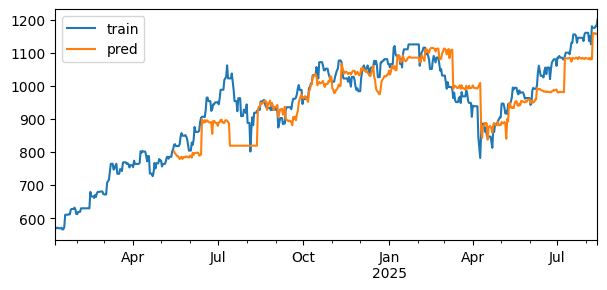

3.6282699040992763

In [4]:
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from sklearn.exceptions import ConvergenceWarning
from xgboost import XGBRegressor
import warnings
from skforecast.exceptions import DataTypeWarning
from sklearn.preprocessing import PowerTransformer, StandardScaler
import matplotlib.pyplot as plt
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from sklearn.linear_model import ElasticNetCV
from catboost import CatBoostRegressor

warnings.simplefilter('ignore', category=DataTypeWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)
metrics = [
    # 'mean_absolute_error',
    'root_mean_squared_scaled_error',
    # 'mean_absolute_percentage_error',
    # 'mean_absolute_scaled_error'
]
params = {'n_estimators': 886, 'learning_rate': 0.10547544711388092, 'max_depth': 4, 'min_child_weight': 1.8358420913969768, 'subsample': 0.9031384324391545, 'colsample_bytree': 0.5429371626580264, 'gamma': 0.004147741847611214, 'reg_alpha': 0.10029560256807972, 'reg_lambda': 0.1793865276660986, "tree_method":"exact", "random_state":42}
forecaster = ForecasterRecursive(
                 regressor       = XGBRegressor(**params),
                 lags            = 8,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[15]),
                 transformer_y   = PowerTransformer(method="box-cox"),
                 transformer_exog= StandardScaler())
tscv = TimeSeriesFold(
    steps=30,                 # predict 30 days at a time
    initial_train_size=128,   # start with 1 year of data
    refit=True,
    window_size=10
)
backtest_metrics, predictions = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = y_train,
                                    cv         = tscv,
                                    metric     = metrics,
                                    exog=x_train, 
                                    show_progress=False)
fig, ax = plt.subplots(figsize=(7, 3))
y_train.plot(ax=ax, label='train')
predictions.plot(ax=ax, label='predictions')
plt.legend()
plt.show()
backtest_metrics.values.item()

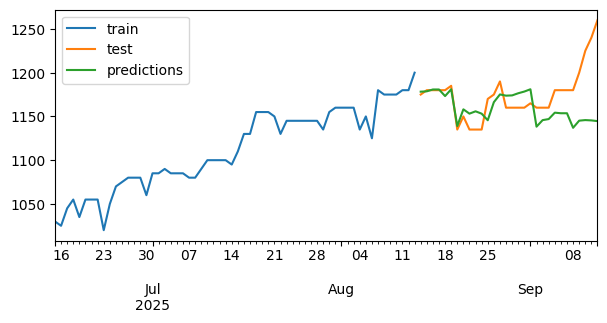

In [6]:
forecaster = ForecasterRecursive(
                 regressor       = XGBRegressor(**params),
                 lags            = 8,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[15]),
                 transformer_y   = PowerTransformer(method="box-cox"),
                 transformer_exog= StandardScaler())
forecaster.fit(y_train, x_train)
predictions = forecaster.predict(steps=len(y_test), exog=x_test)
fig, ax = plt.subplots(figsize=(7, 3))
y_train[-60:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()